# CNN to classify Cifar-10 dataset (Images)



So far, we saw how to build a Dense Neural Network (DNN) that classified images of digits (MNIST) or even fashion images (Fashion-MNIST). Here we will instead, recognize the 10 classes of CIFAR ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship' and 'truck'). There are some key differences between these two image datasets that we need to take into account.

First, while MNIST were 28x28 monochrome images (1 color channel), CIFAR is 32x32 color images (3 color channels).

Second, MNIST images are simple, containing just the object centered in the image, with no background. Conversely, CIFAR ones are not centered and can have the object with a background, such as airplanes that might have a cloudy sky behind them! Those differences are the main reason to use a CNN instead of a DNN.

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten

2025-10-14 18:22:37.160030: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Import and Inspect Dataset

Cifar-10 repository: https://www.cs.toronto.edu/~kriz/cifar.html





In [2]:
cifar10 = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step


In [ ]:
print(train_images.shape, train_labels.shape) # (50000, 32, 32, 3) (50000, 1) 50000 images, 32x32 pixels, 3 color channels (RGB)
print(test_images.shape, test_labels.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


- The image data shape is: `(#images, img_heigth, img_width, #channels)`, where channels are in RGB format (red, green, blue).
- The labels shape is `(#images, label)`, where label goes from 0 to 9.


In [4]:
train_images[1]

array([[[154, 177, 187],
        [126, 137, 136],
        [105, 104,  95],
        ...,
        [ 91,  95,  71],
        [ 87,  90,  71],
        [ 79,  81,  70]],

       [[140, 160, 169],
        [145, 153, 154],
        [125, 125, 118],
        ...,
        [ 96,  99,  78],
        [ 77,  80,  62],
        [ 71,  73,  61]],

       [[140, 155, 164],
        [139, 146, 149],
        [115, 115, 112],
        ...,
        [ 79,  82,  64],
        [ 68,  70,  55],
        [ 67,  69,  55]],

       ...,

       [[175, 167, 166],
        [156, 154, 160],
        [154, 160, 170],
        ...,
        [ 42,  34,  36],
        [ 61,  53,  57],
        [ 93,  83,  91]],

       [[165, 154, 128],
        [156, 152, 130],
        [159, 161, 142],
        ...,
        [103,  93,  96],
        [123, 114, 120],
        [131, 121, 131]],

       [[163, 148, 120],
        [158, 148, 122],
        [163, 156, 133],
        ...,
        [143, 133, 139],
        [143, 134, 142],
        [143, 133, 144]]

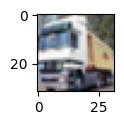

In [8]:
plt.figure(figsize=(1,1))
plt.imshow(train_images[1]);

In [ ]:
train_labels[1][0] # 9 = truck

np.uint8(9)

    The CIFAR labels happen to be arrays, which is why you need the extra index

In [10]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
class_names[9] # The List's index is the label # 9 = truck

'truck'

In [12]:
idx = train_labels[1][0]
class_names[idx]

'truck'

	 truck


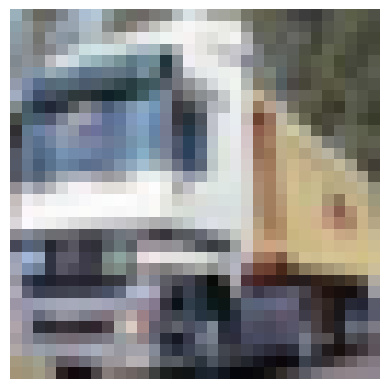

In [13]:
print("\t", class_names[train_labels[1][0]])
plt.imshow(train_images[1])
plt.axis('off');

In [14]:
 def plot_train_img(img, size=2):
    label = train_labels[img][0]
    plt.figure(figsize=(size,size))
    print("Label {} - {}".format(label, class_names[label]))
    plt.imshow(train_images[img])
    plt.axis('off')
    plt.show()

Label 9 - truck


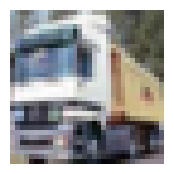

In [15]:
plot_train_img(1)

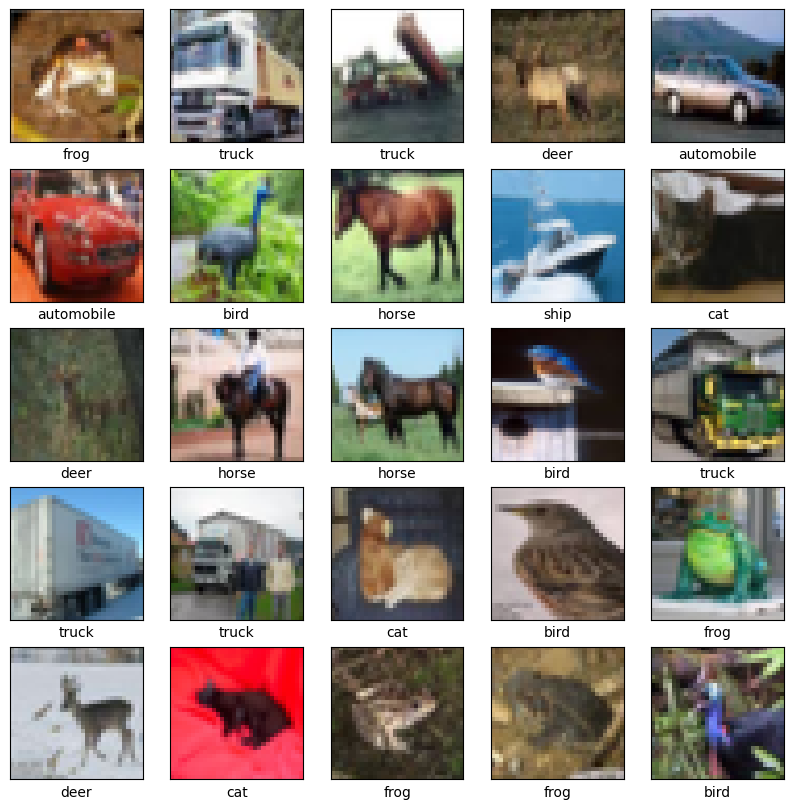

In [16]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

Note that images are in color, not centered and with different backgrounds

## Preprocessing dataset

In [17]:
test_images.max()

np.uint8(255)

In [18]:
# Normalize pixel values to be between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

In [ ]:
test_images.max() # 1.0

np.float64(1.0)

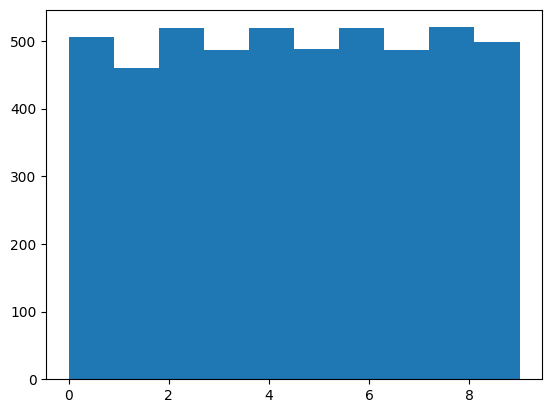

In [ ]:
plt.hist(train_labels[:5_000]); # 5_000 images

In [ ]:
val_images = train_images[:5_000] # 5_000 images for validation
val_labels = train_labels[:5_000]
print(val_images.shape, val_labels.shape)

(5000, 32, 32, 3) (5000, 1)


In [ ]:
train_images = train_images[5_000:] # 45_000 images for training
train_labels = train_labels[5_000:] # 45_000 labels for training
print(train_images.shape, train_labels.shape)

(45000, 32, 32, 3) (45000, 1)


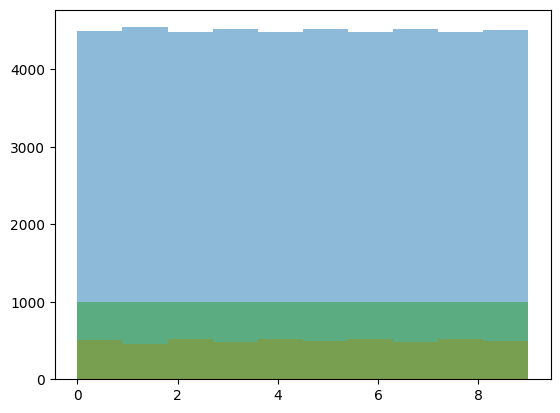

In [ ]:
plt.hist(train_labels, alpha=0.5) # 45_000 images for training
plt.hist(val_labels, alpha=0.5) # 5_000 images for validation
plt.hist(test_labels, alpha=0.5); # 10_000 images for testing

## Create Model Arquitecture and Compile

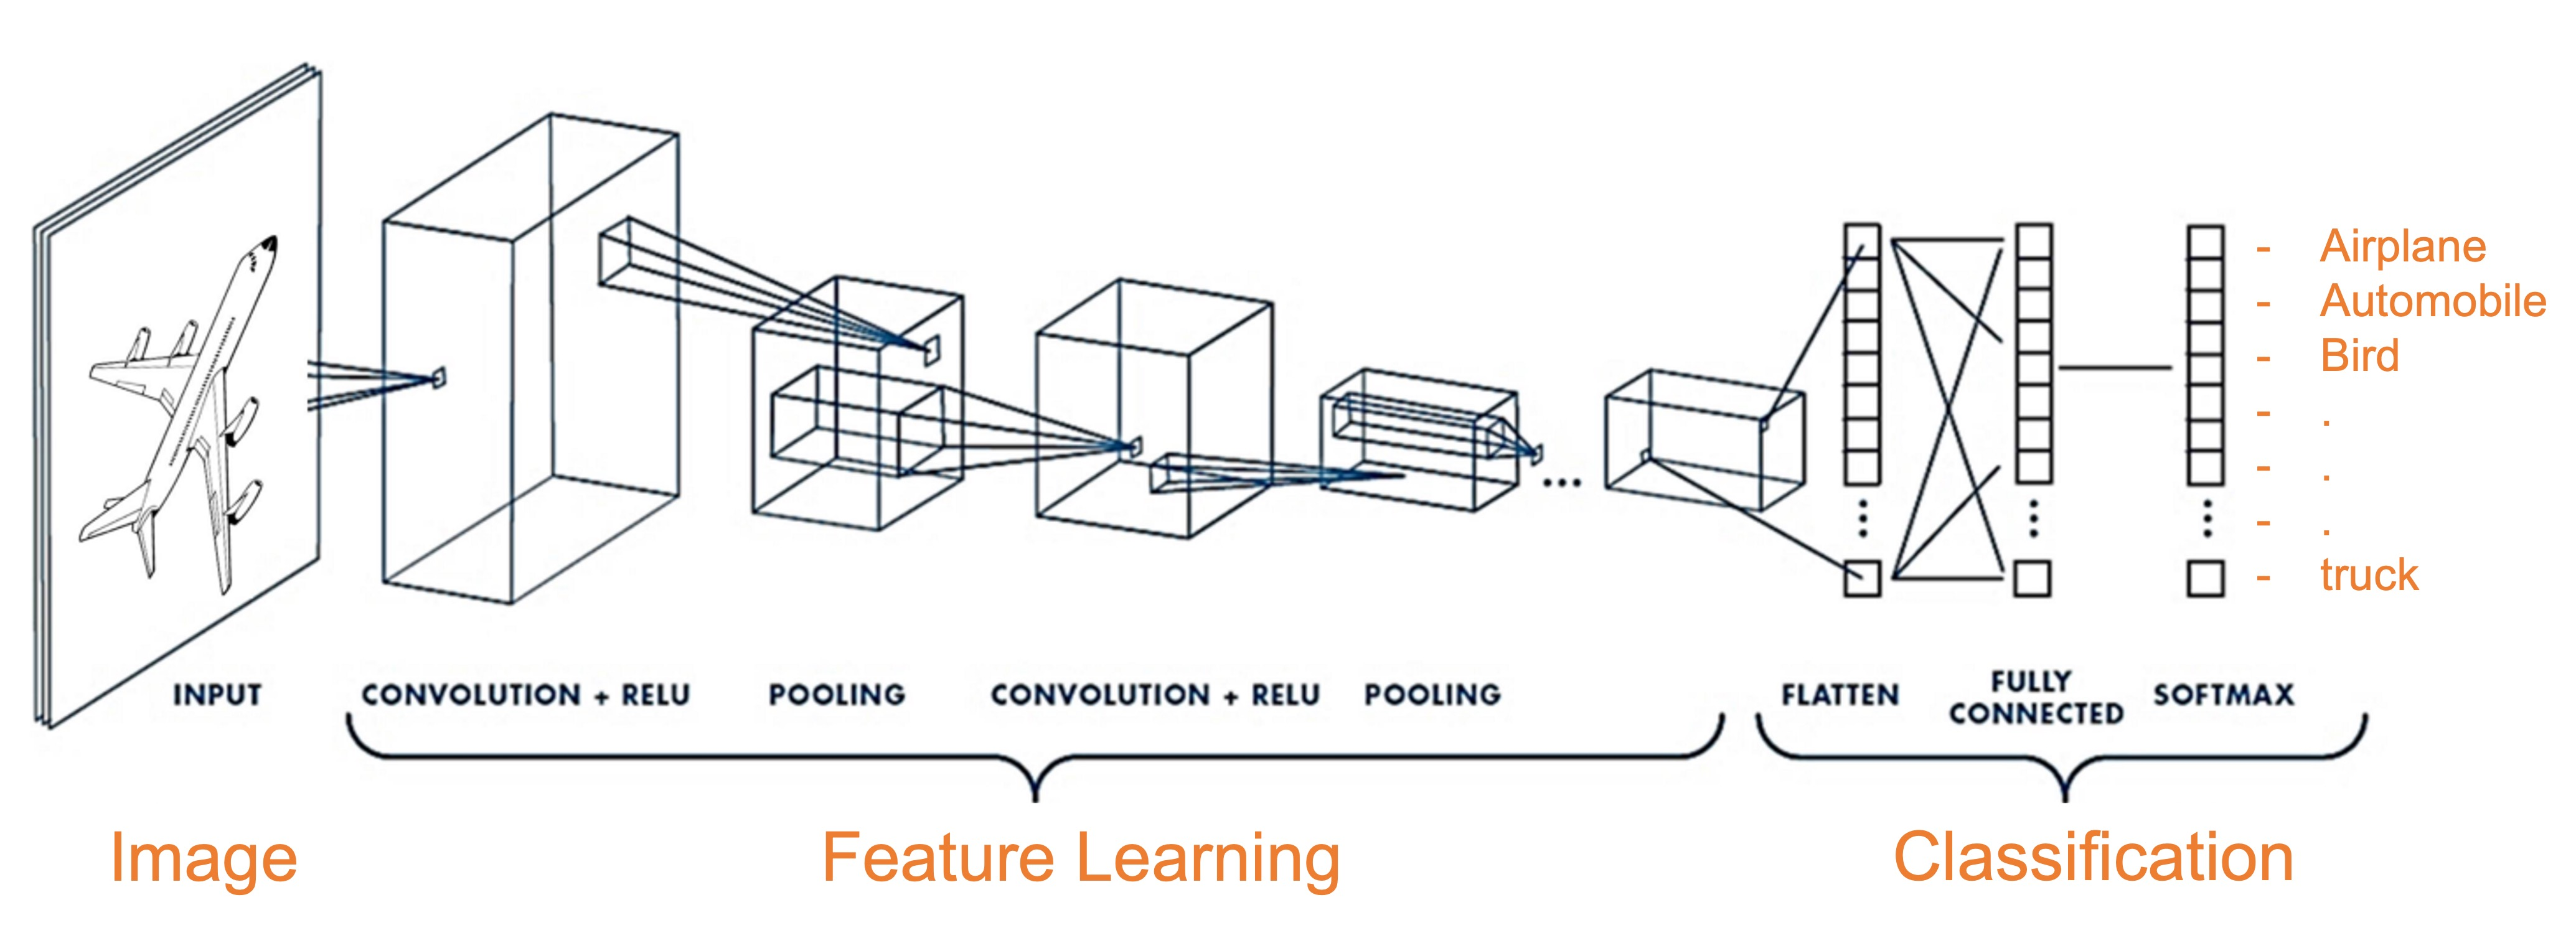

On [Convolution layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D),
- strides is an integer or tuple/list of 2 integers, specifying the strides of the convolution along the height and width. Default (1,1).
- padding: one of "valid" or "same" (case-insensitive). Default = 'valid'.
  - "valid" means no padding.  
  - "same" results in padding with zeros evenly
to the left/right or up/down of the input such that output has the same


In [25]:
model = Sequential() # Sequential model - a linear stack of layers

model.add(Conv2D( # Convolutional layer
    input_shape=(32, 32, 3),
    filters=32, # Number of filters to use (also called kernels)
    kernel_size=(3,3), # Size of the filter (3x3 pixels)
    activation='relu') # Activation function (ReLU - Rectified Linear Unit)
)
model.add(MaxPool2D(2, 2)) # Max Pooling layer - downsample the input by taking the maximum value over a 2x2 pooling window

model.add(Conv2D(64, (3,3), activation='relu')) # Another Convolutional layer
model.add(MaxPool2D()) # Another Max Pooling layer

model.add(Flatten()) # Flatten the 3D output to 1D
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,562 (654.54 KB)

 Trainable params: 167,562 (654.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
LOSS = 'sparse_categorical_crossentropy' # Loss function for multi-class classification
OPTIMIZER = 'adam'

# Compile the model
model.compile(optimizer=OPTIMIZER,
              loss=LOSS,
              metrics=['accuracy'])

## Training

In [27]:
NUM_EPOCHS = 20 #You can change this value if you like to experiment with it to get better accuracy

In [28]:
# Fit the model
history = model.fit(train_images,
                    train_labels,
                    epochs=NUM_EPOCHS,
                    validation_data=(val_images, val_labels)
)

Epoch 1/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 31s 19ms/step - accuracy: 0.4699 - loss: 1.4743 - val_accuracy: 0.5578 - val_loss: 1.2945
Epoch 2/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.6073 - loss: 1.1248 - val_accuracy: 0.6316 - val_loss: 1.0606
Epoch 3/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.6570 - loss: 0.9850 - val_accuracy: 0.6616 - val_loss: 0.9767
Epoch 4/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step - accuracy: 0.6860 - loss: 0.9013 - val_accuracy: 0.6726 - val_loss: 0.9415
Epoch 5/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.7098 - loss: 0.8328 - val_accuracy: 0.6848 - val_loss: 0.9086
Epoch 6/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 25s 18ms/step - accuracy: 0.7296 - loss: 0.7758 - val_accuracy: 0.6738 - val_loss: 0.9972
Epoch 7/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step - accuracy: 0.7493 - loss: 0.7225 - val_accuracy: 0.6864 - val_loss: 0.9265
Epoch 8/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step - accuracy: 0.7652 -

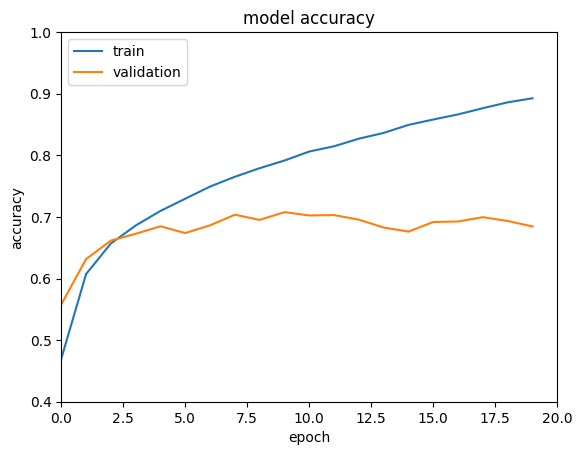

In [29]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.xlim([0,NUM_EPOCHS])
plt.ylim([0.4,1.0])
plt.show()

## Evaluate Model

In [30]:
print("Train data: ", model.evaluate(train_images, train_labels)[1])
print("Eval data: ", model.evaluate(val_images, val_labels)[1])
print("Test data: ", model.evaluate(test_images, test_labels)[1])

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9031 - loss: 0.2707
Train data:  0.9030666947364807
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6846 - loss: 1.2877
Eval data:  0.6845999956130981
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6799 - loss: 1.3634
Test data:  0.6798999905586243


**Accuracy**
- Train: +90%;
- Validation: 68%-70%
- Test: 66%-68%

In [31]:
predictions = np.argmax(model.predict(test_images), axis=-1)
predictions.shape

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


(10000,)

In [32]:
from sklearn.metrics import classification_report,confusion_matrix

In [33]:
print(classification_report(test_labels, predictions, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.72      0.73      0.73      1000
  automobile       0.79      0.80      0.80      1000
        bird       0.57      0.63      0.60      1000
         cat       0.51      0.43      0.47      1000
        deer       0.73      0.53      0.61      1000
         dog       0.47      0.73      0.57      1000
        frog       0.83      0.70      0.76      1000
       horse       0.72      0.72      0.72      1000
        ship       0.78      0.79      0.78      1000
       truck       0.81      0.73      0.77      1000

    accuracy                           0.68     10000
   macro avg       0.69      0.68      0.68     10000
weighted avg       0.69      0.68      0.68     10000



In [34]:
confusion_matrix(test_labels,predictions)

array([[735,  23,  61,  21,  10,  18,   3,  15,  92,  22],
       [ 31, 804,  14,   9,   4,  13,   8,  11,  28,  78],
       [ 59,   5, 634,  59,  38, 116,  27,  36,  16,  10],
       [ 28,   8,  70, 429,  41, 314,  40,  40,  18,  12],
       [ 32,   5, 106,  75, 532, 108,  40,  86,  11,   5],
       [ 17,   6,  47, 108,  22, 727,  10,  52,   7,   4],
       [  5,  11,  84,  67,  35,  79, 699,  10,   6,   4],
       [ 15,   8,  49,  39,  36, 109,   5, 719,   9,  11],
       [ 65,  40,  26,  15,   9,  21,   3,   6, 791,  24],
       [ 37, 111,  14,  15,   4,  26,   9,  17,  38, 729]])

In [35]:
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

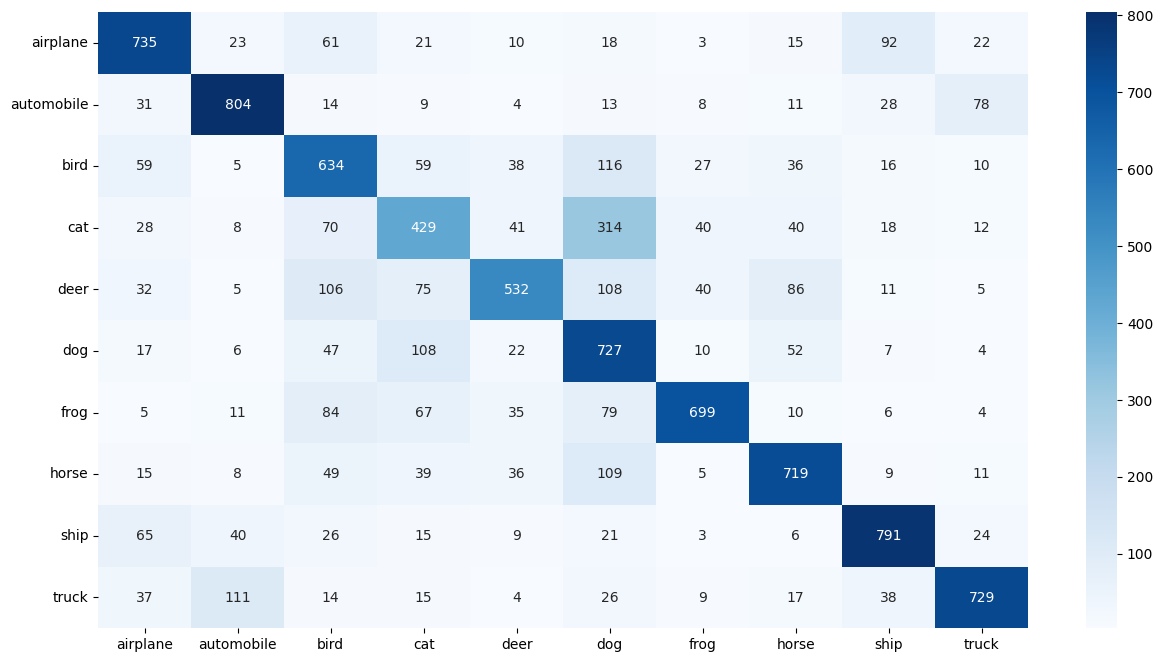

In [38]:
import seaborn as sns
plt.figure(figsize=(15,8))
sns.heatmap(confusion_matrix(test_labels,predictions), cmap='Blues', annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names);

## Testing Model (Predicting)

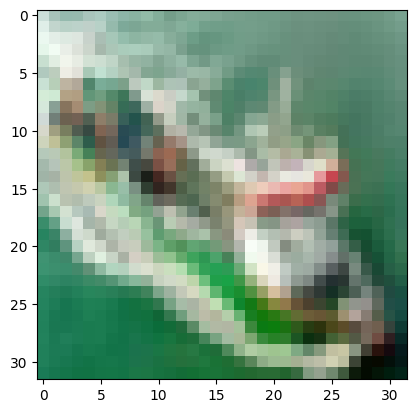

In [39]:
plt.imshow(test_images[15]);

In [40]:
test_labels[15][0]

np.uint8(8)

In [41]:
class_names[8]

'ship'

In [42]:
test_images[15].shape

(32, 32, 3)

The input Tensor shape should be: (num_images, width, height, color_channels)

In [43]:
my_image = test_images[15]
my_image = my_image.reshape(1,32,32,3)
my_image.shape

(1, 32, 32, 3)

In [44]:
img_pred = np.argmax(model.predict(my_image))
class_names[img_pred]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


'ship'

In [45]:
def img_pred(img, size=4):
    label = test_labels[img][0]
    my_image = test_images[img]
    plt.figure(figsize=(size,size))
    plt.imshow(my_image)
    my_image = my_image.reshape(1,32,32,3)
    img_pred = np.argmax(model.predict(my_image))
    pred_label = class_names[img_pred]
    print(" Label {} <=> Pred: {}".format(class_names[label], pred_label))
    plt.grid(False)
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
 Label ship <=> Pred: ship


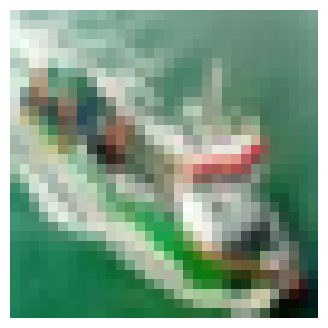

In [46]:
img_pred(15)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
 Label cat <=> Pred: cat


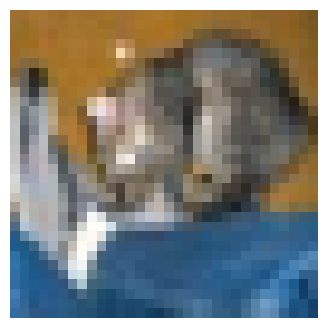

In [47]:
img_pred(0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
 Label ship <=> Pred: ship


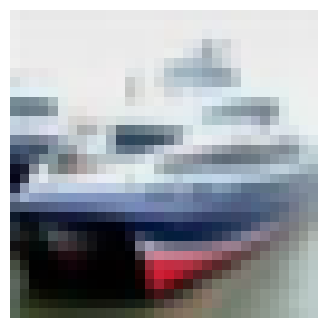

In [48]:
img_pred(1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
 Label ship <=> Pred: ship


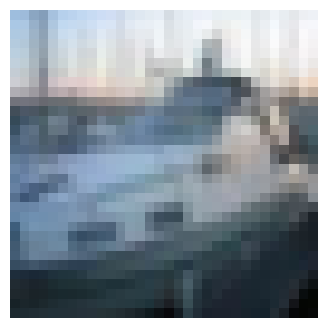

In [49]:
img_pred(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
 Label airplane <=> Pred: airplane


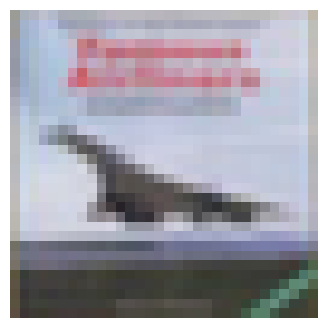

In [50]:
img_pred(3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
 Label frog <=> Pred: deer


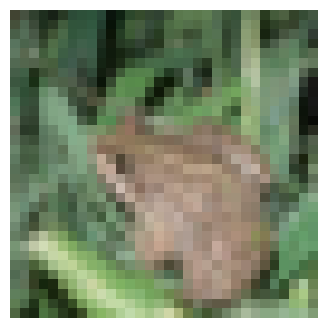

In [51]:
img_pred(4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
 Label frog <=> Pred: frog


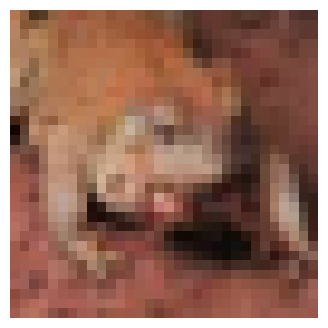

In [52]:
img_pred(5)

## Saving the model

In [53]:
!pwd # Linux command, shows where we are in CoLab's folders

/home/leohf/machine_learning/Tensorflow-1


In [54]:
model.save('cifar_10_model.h5')

Use [Netron](https://netron.app) to visualize the model, hyperparameters, tensor shapes, etc. Netron is a viewer for neural network, deep learning and machine learning models (See [GitHub](https://github.com/lutzroeder/netron) for instructions about instalation in your desktop).